<a href="https://colab.research.google.com/github/mirna-k/MRI-image-reconstruction/blob/main/img_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
file = "/content/file_brain_AXFLAIR_201_6002986.h5"
hf = h5py.File(file)

In [29]:
print('Keys: ', list(hf.keys()))
print('Attr: ', dict(hf.attrs))

Keys:  ['ismrmrd_header', 'kspace', 'mask']
Attr:  {'acceleration': 4, 'acquisition': 'AXFLAIR', 'num_low_frequency': 26, 'patient_id': 'd6ff767f709ddc69f964a4fc5f438f409f6289b5f88ad5477bffe8f1902cbd3f'}


# *Image acquiring (notes)
### Acquiring Data in K-space:
During an MRI scan, the MRI machine acquires data by sampling different points in k-space.
The process involves applying magnetic gradients and radiofrequency pulses to the tissue, and the resulting signals are collected at different points in k-space.

### Data Structure in K-space:
K-space data is typically a set of complex numbers, each representing the amplitude and phase of a particular spatial frequency component.
The center of k-space corresponds to low spatial frequencies (e.g., smooth transitions in the image), while the outer regions correspond to high spatial frequencies (e.g., fine details).

**AXFLAIR**:
Fluid attenuated inversion recovery (FLAIR) is a special inversion recovery sequence with a long inversion time. This removes signal from the cerebrospinal fluid in the resulting images

In [30]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(14, 16, 640, 320)


In [55]:
slice_kspace = volume_kspace[7]

In [49]:
def show_slices(data, slice_nums, cmap=None):
  fig = plt.figure()
  for i, num in enumerate(slice_nums):
    plt.subplot(1, len(slice_nums), i + 1)
    plt.imshow(data[num], cmap=cmap)

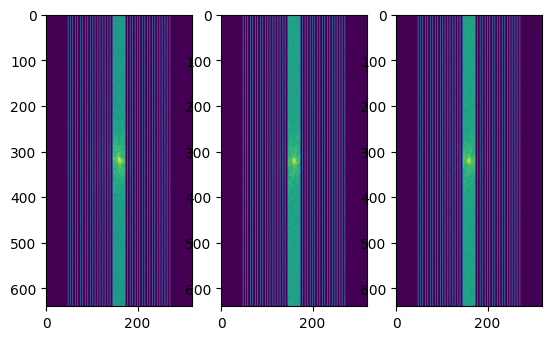

In [56]:
show_slices(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])

# FastMRI functions
source: https://github.com/facebookresearch/fastMRI/tree/main

In [61]:
from typing import List, Optional
import torch

In [35]:
def roll_one_dim(x: torch.Tensor, shift: int, dim: int) -> torch.Tensor:
    """
    Similar to roll but for only one dim.

    Args:
        x: A PyTorch tensor.
        shift: Amount to roll.
        dim: Which dimension to roll.

    Returns:
        Rolled version of x.
    """
    shift = shift % x.size(dim)
    if shift == 0:
        return x

    left = x.narrow(dim, 0, x.size(dim) - shift)
    right = x.narrow(dim, x.size(dim) - shift, shift)

    return torch.cat((right, left), dim=dim)

In [36]:
def roll(
    x: torch.Tensor,
    shift: List[int],
    dim: List[int],
) -> torch.Tensor:
    """
    Similar to np.roll but applies to PyTorch Tensors.

    Args:
        x: A PyTorch tensor.
        shift: Amount to roll.
        dim: Which dimension to roll.

    Returns:
        Rolled version of x.
    """
    if len(shift) != len(dim):
        raise ValueError("len(shift) must match len(dim)")

    for (s, d) in zip(shift, dim):
        x = roll_one_dim(x, s, d)

    return x


In [37]:
def ifftshift(x: torch.Tensor, dim: Optional[List[int]] = None) -> torch.Tensor:
    """
    Similar to np.fft.ifftshift but applies to PyTorch Tensors

    Args:
        x: A PyTorch tensor.
        dim: Which dimension to ifftshift.

    Returns:
        ifftshifted version of x.
    """
    if dim is None:
        # this weird code is necessary for toch.jit.script typing
        dim = [0] * (x.dim())
        for i in range(1, x.dim()):
            dim[i] = i

    # also necessary for torch.jit.script
    shift = [0] * len(dim)
    for i, dim_num in enumerate(dim):
        shift[i] = (x.shape[dim_num] + 1) // 2

    return roll(x, shift, dim)

In [38]:
def fftshift(x: torch.Tensor, dim: Optional[List[int]] = None) -> torch.Tensor:
    """
    Similar to np.fft.fftshift but applies to PyTorch Tensors

    Args:
        x: A PyTorch tensor.
        dim: Which dimension to fftshift.

    Returns:
        fftshifted version of x.
    """
    if dim is None:
        # this weird code is necessary for toch.jit.script typing
        dim = [0] * (x.dim())
        for i in range(1, x.dim()):
            dim[i] = i

    # also necessary for torch.jit.script
    shift = [0] * len(dim)
    for i, dim_num in enumerate(dim):
        shift[i] = x.shape[dim_num] // 2

    return roll(x, shift, dim)

In [39]:
def ifft2(data: torch.Tensor, norm: str = "ortho") -> torch.Tensor:
    """
    Apply centered 2-dimensional Inverse Fast Fourier Transform.

    Args:
        data: Complex valued input data containing at least 3 dimensions:
            dimensions -3 & -2 are spatial dimensions and dimension -1 has size
            2. All other dimensions are assumed to be batch dimensions.
        norm: Normalization mode. See ``torch.fft.ifft``.

    Returns:
        The IFFT of the input.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    data = ifftshift(data, dim=[-3, -2])
    data = torch.view_as_real(
        torch.fft.ifftn(  # type: ignore
            torch.view_as_complex(data), dim=(-2, -1), norm=norm
        )
    )
    data = fftshift(data, dim=[-3, -2])

    return data


In [25]:
def complex_abs(data: torch.Tensor) -> torch.Tensor:
    """
    Compute the absolute value of a complex valued input tensor.

    Args:
        data: A complex valued tensor, where the size of the final dimension
            should be 2.

    Returns:
        Absolute value of data.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    return (data**2).sum(dim=-1).sqrt()

In [41]:
def to_tensor(data: np.ndarray) -> torch.Tensor:
    """
    Convert numpy array to PyTorch tensor.

    For complex arrays, the real and imaginary parts are stacked along the last
    dimension.

    Args:
        data: Input numpy array.

    Returns:
        PyTorch version of data.
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)

# Spatial domain images

In [57]:
slice_kspace2 = to_tensor(slice_kspace)
slice_image = ifft2(slice_kspace2)
slice_image_abs = complex_abs(slice_image)

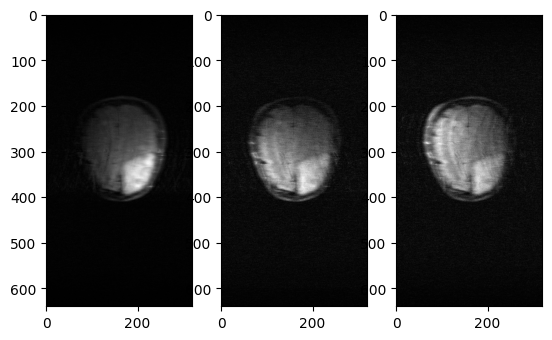

In [58]:
show_slices(slice_image_abs, [0, 5, 10], cmap='gray')

In [45]:
def rss(data: torch.Tensor, dim: int = 0) -> torch.Tensor:
    """
    Compute the Root Sum of Squares (RSS).

    RSS is computed assuming that dim is the coil dimension.

    Args:
        data: The input tensor
        dim: The dimensions along which to apply the RSS transform

    Returns:
        The RSS value.
    """
    return torch.sqrt((data**2).sum(dim))

In [59]:
slice_image_rss = rss(slice_image_abs, dim=0)

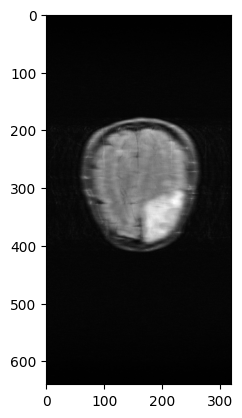

In [60]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')